In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm
import os
from joblib import Parallel, delayed

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import r2_score

# 1) Reuse your existing function or adapt it to sum mass in each box
def get_box_mass_distribution(array, size, mask=None, x_offset=0, y_offset=0):
    """
    Partition 'array' into boxes of shape (size, size) with a given offset,
    and return the normalized mass distribution p_i = m_i / sum_j m_j
    for all boxes that fit fully in the array.

    Args:
        array (np.ndarray): 2D array (can be float or int).
        size (int): Box size in pixels.
        mask (np.ndarray, optional): 2D binary mask of the same shape as 'array'.
                                     If provided, only sum mass where mask==1.
        x_offset, y_offset (int): Offsets for the box tiling.

    Returns:
        p (np.ndarray): 1D array of probabilities (m_i / total_mass).
                       Length is the number of boxes that fit the shape.
    """
    shape = array.shape
    num_boxes_x = (shape[0] - x_offset) // size
    num_boxes_y = (shape[1] - y_offset) // size

    if num_boxes_x <= 0 or num_boxes_y <= 0:
        return np.array([])

    # End indices to ensure complete boxes
    end_x = x_offset + num_boxes_x * size
    end_y = y_offset + num_boxes_y * size

    sliced_array = array[x_offset:end_x, y_offset:end_y]
    if mask is not None:
        sliced_mask = mask[x_offset:end_x, y_offset:end_y]
        # Multiply to zero-out areas outside the mask
        sliced_array = sliced_array * sliced_mask
    
    # Reshape into boxes of (size, size)
    reshaped = sliced_array.reshape(num_boxes_x, size, num_boxes_y, size)
    # Move axes to group each box in one dimension
    reshaped = reshaped.transpose(0, 2, 1, 3)  # shape: (num_boxes_x, num_boxes_y, size, size)

    # Sum each box
    box_masses = reshaped.sum(axis=(2, 3)).ravel()  # shape: (num_boxes_x * num_boxes_y,)

    total_mass = box_masses.sum()
    if total_mass <= 0:
        return np.array([])

    # Normalize to get a probability distribution
    p = box_masses / total_mass
    return p


def get_box_probabilities(array, size, mask=None, num_offsets=1):
    """
    Compute the probability distribution p_i (m_i / total_mass) for a given box size.
    Tries multiple offsets and returns the distribution for the offset that yields
    the largest coverage (or just merges them). However, typically you'd pick the
    *centered* offset or test them all. For fractal dimension calculations,
    either approach can work. Here we pick the first offset's distribution
    or optionally average them.

    Args:
        array (np.ndarray): 2D array.
        size (int): Box size in pixels.
        mask (np.ndarray, optional): 2D binary mask.
        num_offsets (int, optional): Number of random offsets to test.

    Returns:
        p (np.ndarray): Probability distribution for the chosen offset.
    """
    shape = array.shape
    # Centered offset
    centered_x_offset = (shape[0] % size) // 2
    centered_y_offset = (shape[1] % size) // 2

    p_list = []

    # Always include the centered offset
    offsets = [(centered_x_offset, centered_y_offset)]

    # Generate random offsets if needed
    total_possible_offsets = size * size
    if num_offsets > 1 and total_possible_offsets > 1:
        # exclude (center_x_offset, center_y_offset) from random picks
        all_indices = [(ix, iy) 
                       for ix in range(size) for iy in range(size)]
        all_indices.remove((centered_x_offset, centered_y_offset))
        # pick random offsets
        chosen = np.random.choice(range(len(all_indices)), size=num_offsets-1, replace=False)
        random_offsets = [all_indices[i] for i in chosen]
        offsets.extend(random_offsets)
    
    # Gather probability distributions
    for (x_off, y_off) in offsets:
        p = get_box_mass_distribution(array, size, mask, x_off, y_off)
        if len(p) > 0:
            p_list.append(p)
    
    if not p_list:
        return np.array([])

    # For simplicity, just return the distribution of the first offset
    # (Or you could average distributions across offsets if you prefer)
    return p_list[0]


def compute_mass_fractal_dimension(
    array,
    sizes,
    q=2,
    mask=None,
    num_offsets=1
):
    """
    Compute the 'mass fractal dimension' associated with the Rényi dimension D_q,
    using box-partition sums for a range of box sizes.

    D_q = 1/(q-1) * slope( ln( sum_i p_i^q ) vs. ln(1/epsilon) )

    Args:
        array (np.ndarray): 2D array representing intensity/mass distribution.
        sizes (list): List of box sizes (integers).
        q (float): Rényi parameter (e.g. 2 = correlation dimension).
        mask (np.ndarray, optional): Binary mask restricting region of interest.
        num_offsets (int, optional): Number of offsets to try.

    Returns:
        (valid_sizes, yvals, Dq, fit_params, r2):
            valid_sizes (np.ndarray): the box sizes used (filtered if needed)
            yvals (np.ndarray): the log( sum_i p_i^q ) values
            Dq (float): Estimated mass fractal dimension for q
            fit_params (np.ndarray): [slope, intercept] from np.polyfit
            r2 (float): R^2 of the linear fit
    """
    log_epsilon = []
    log_sum_p_q = []

    for size in tqdm(sizes, desc="Mass fractal dimension", leave=False):
        p = get_box_probabilities(array, size, mask, num_offsets=num_offsets)
        if len(p) == 0:
            continue

        sum_p_q = np.sum(p**q)
        # x-axis: ln(1/epsilon) ~ -ln(epsilon) but epsilon ~ size in pixel units
        # We'll just take log10 for convenience
        log_epsilon.append(-np.log10(size))
        log_sum_p_q.append(np.log10(sum_p_q))

    log_epsilon = np.array(log_epsilon)
    log_sum_p_q = np.array(log_sum_p_q)

    # Filter valid points
    valid = (~np.isnan(log_epsilon)) & (~np.isnan(log_sum_p_q))
    log_epsilon = log_epsilon[valid]
    log_sum_p_q = log_sum_p_q[valid]

    if len(log_epsilon) < 2:
        return np.array([]), np.array([]), np.nan, np.array([np.nan, np.nan]), np.nan

    # Linear fit: log_sum_p_q = slope * log_epsilon + intercept
    fit, cov = np.polyfit(log_epsilon, log_sum_p_q, 1, cov=True)
    slope, intercept = fit
    # R^2
    from sklearn.metrics import r2_score
    y_pred = slope * log_epsilon + intercept
    r2 = r2_score(log_sum_p_q, y_pred)

    # D_q = slope / (q-1), but note the sign flips because we used -log10(size)
    # Actually slope = d/d(-log10(size)) of log10( sum_i p_i^q ) => we have to be consistent
    # By standard formulas: D_q = - slope / (q - 1) if we plotted log_sum_p_q vs. log(size)
    # but we used -log10(size). Carefully we get an extra minus sign:
    #    slope_ours = d[log_sum_p_q]/d[-log10(size)] = - d[log_sum_p_q]/d[log10(size)]
    # => actual slope wrt log10(size) is -slope_ours.
    # => D_q = -(-slope_ours)/(q-1) = slope_ours/(q-1).
    # Double-check with a quick example. If slope_ours is positive, D_q is positive for q>1.
    # We'll go with:
    D_q = slope / (q - 1)

    return (sizes[valid], log_sum_p_q, D_q, fit, r2)


def compute_information_dimension(
    array,
    sizes,
    mask=None,
    num_offsets=1
):
    """
    Compute the 'information dimension' D_1 using Shannon entropy H(ε):
       D_1 = slope of [H(ε) vs. ln(1/ε)]
    in a box-partition approach.

    Args:
        array (np.ndarray): 2D array representing intensity/mass distribution.
        sizes (list): List of box sizes (integers).
        mask (np.ndarray, optional): Binary mask restricting region of interest.
        num_offsets (int, optional): Number of offsets to try.

    Returns:
        (valid_sizes, Hvals, D1, fit_params, r2):
            valid_sizes (np.ndarray): the box sizes used
            Hvals (np.ndarray): the computed entropies
            D1 (float): estimated information dimension
            fit_params (np.ndarray): [slope, intercept] from np.polyfit
            r2 (float): R^2 of the linear fit
    """
    log_epsilon = []
    entropies = []

    for size in tqdm(sizes, desc="Information dimension", leave=False):
        p = get_box_probabilities(array, size, mask, num_offsets=num_offsets)
        if len(p) == 0:
            continue

        # Shannon entropy
        # Avoid log(0) by adding a small epsilon or ignoring zero p_i
        p_nonzero = p[p > 0]
        H = -np.sum(p_nonzero * np.log(p_nonzero))  # natural log

        log_epsilon.append(-np.log10(size))  # effectively log10(1/size)
        entropies.append(H)

    log_epsilon = np.array(log_epsilon)
    entropies = np.array(entropies)

    valid = (~np.isnan(log_epsilon)) & (~np.isnan(entropies))
    log_epsilon = log_epsilon[valid]
    entropies = entropies[valid]

    if len(log_epsilon) < 2:
        return np.array([]), np.array([]), np.nan, np.array([np.nan, np.nan]), np.nan

    # Linear fit of H vs. log_epsilon
    fit, cov = np.polyfit(log_epsilon, entropies, 1, cov=True)
    slope, intercept = fit

    from sklearn.metrics import r2_score
    y_pred = slope * log_epsilon + intercept
    r2 = r2_score(entropies, y_pred)

    # Interpreting the slope:
    #   H(ε) ~ D_1 * ln(1/ε) => in base e, or D_1 * log10(1/ε) up to constants.
    # If we used natural log for H but log10 for epsilon, we get D_1 = slope * (ln(10)).
    # However, in fractal dimension calculations, people often just take the slope
    # as a direct measure if everything is consistent. To be precise, one might
    # multiply by (1 / ln(10)) if you want the dimension in base e. 
    # For simplicity, let's keep the direct slope as "D1" understanding
    # it depends on the mixing of log bases. 
    D1 = slope  # up to a constant factor if mixing base e vs base 10 logs.

    return (sizes[valid], entropies, D1, fit, r2)


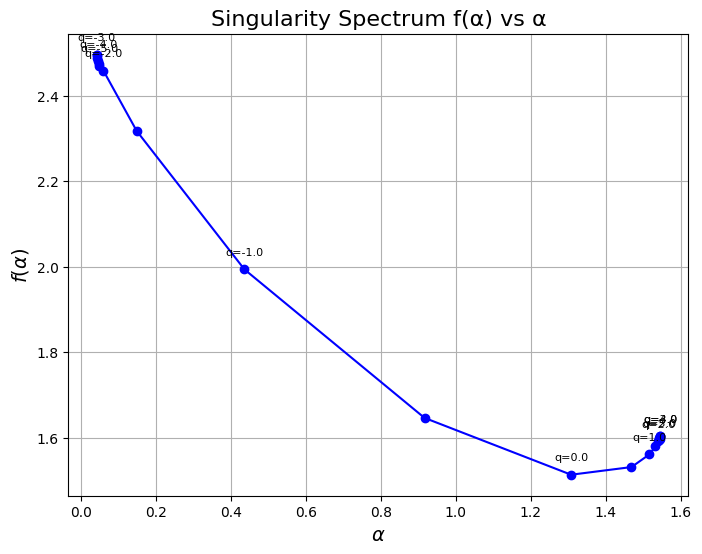

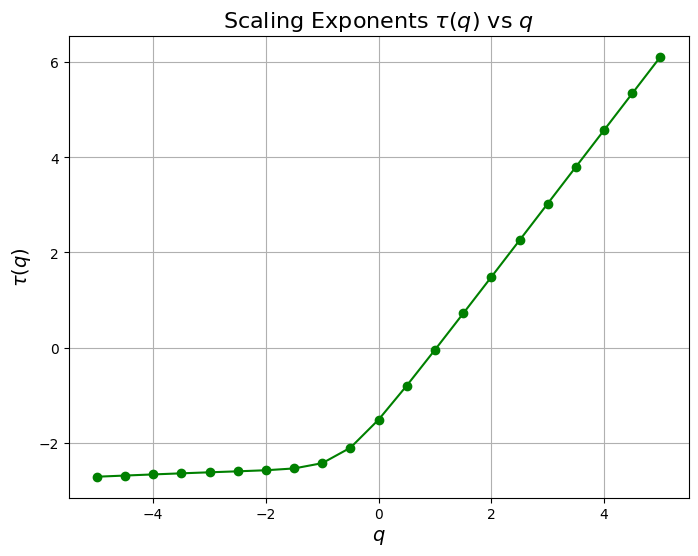

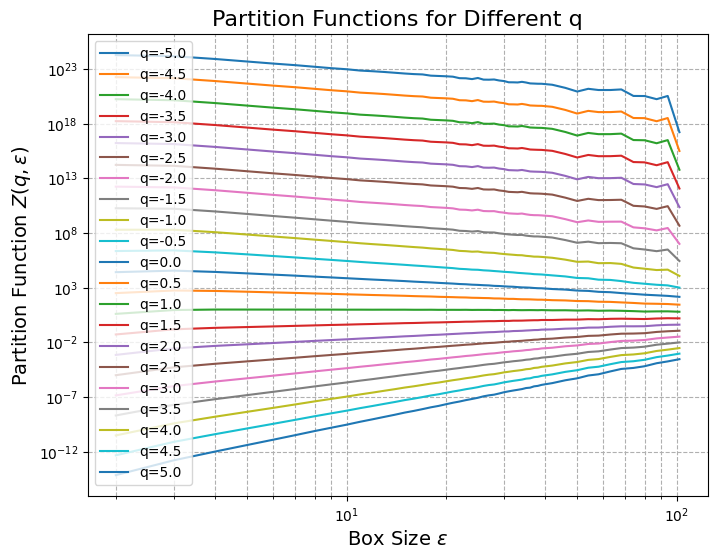

In [5]:

def invert_array(arr):
    if arr.max() <= 1:
        # Handle binary arrays (0,1) by flipping 0 to 1 and 1 to 0
        return np.where(arr == 0, 1, 0)
    elif arr.max() <= 255:
        # Handle uint8 arrays (0 to 255) by subtracting from 255
        return 255 - arr
    else:
        raise ValueError("Array values exceed expected range for binary or uint8 format.")

def process_image_to_array(file_path, threshold=None, invert = False):
    image_array = io.imread(file_path)
    
    # Convert to grayscale by averaging channels if it's not already
    if len(image_array.shape) == 3:
        image_array = image_array.mean(axis=2)
    
    # Binarize the image with the given threshold
    if threshold is None:
        threshold = image_array.mean()
    elif threshold == 'min':
        threshold = image_array.min()
    elif threshold == 'max':
        threshold = image_array.max()
    else:
        if threshold < image_array.min() or threshold > image_array.max():
            raise ValueError(f"Threshold {threshold} is out of the range of image values ({image_array.min()} to {image_array.max()}).")

    binary_image_array = (image_array >= threshold).astype(int)

    # Optionally invert the binary image
    if invert:
        binary_image_array = invert_array(binary_image_array)

    return binary_image_array

def pad_image_for_boxcounting(array, max_size, pad_factor=2, invert=False):
    """
    Pads the image to ensure all boxes fit within the array boundaries.

    Args:
        array (np.ndarray): 2D binary numpy array to pad.
        max_size (int): Largest box size in pixels.
        pad_factor (float, optional): Factor to determine padding size. Defaults to 2.
        invert (bool, optional): If True, invert the array before padding.

    Returns:
        np.ndarray: Padded 2D binary numpy array.
    """
    if invert:
        array = invert_array(array)
    
    # Calculate padding size based on the largest box size and pad factor
    pad_size = int(np.ceil(max_size * pad_factor))
    
    # Pad the array with zeros on all sides
    padded_array = np.pad(array, pad_width=pad_size, mode='constant', constant_values=0)
    
    return padded_array

def define_measure(array, mask=None):
    """
    Define a measure μ on the binary image.
    
    Args:
        array (np.ndarray): 2D binary numpy array.
        mask (np.ndarray, optional): Optional binary mask. Defaults to None.
        
    Returns:
        np.ndarray: 2D array representing the measure μ.
    """
    if mask is not None:
        array = array * mask  # Apply mask
    
    # Ensure the array is binary
    array = (array > 0).astype(float)
    
    # Total mass
    total_mass = np.sum(array)
    if total_mass == 0:
        raise ValueError("Total mass of the measure is zero. Check the input array and mask.")
    
    # Define the measure μ
    mu = array / total_mass
    
    return mu

def get_sizes(num_sizes, minsize, maxsize):
    sizes = list(np.around(np.geomspace(minsize, maxsize, num_sizes)).astype(int))
    for index in range(1, len(sizes)):
        size = sizes[index]
        prev_size = sizes[index - 1]
        if size <= prev_size:
            sizes[index] = prev_size + 1
            if prev_size == maxsize:
                return sizes[:index]
    return sizes

def get_box_sums(mu, size, mask=None, num_offsets=1):
    """
    Compute the sums μ(B) for all boxes of a given size and offsets.
    
    Args:
        mu (np.ndarray): 2D array representing the measure μ.
        size (int): Size of the boxes.
        mask (np.ndarray, optional): Optional binary mask. Defaults to None.
        num_offsets (int, optional): Number of grid offsets to test. Defaults to 1.
        
    Returns:
        np.ndarray: 1D array of μ(B) sums across all boxes and offsets.
    """
    shape = mu.shape
    box_sums = []
    
    # Step 1: Calculate the centered grid offset
    centered_x_offset = (shape[0] % size) // 2
    centered_y_offset = (shape[1] % size) // 2
    
    # Step 2: Determine total possible unique offsets
    total_possible_offsets = size ** 2
    num_offsets = min(num_offsets, total_possible_offsets)
    
    # Step 3: Generate random offsets if num_offsets > 1
    if num_offsets > 1 and total_possible_offsets > 1:
        # Exclude the centered grid from random offsets
        random_indices = np.random.choice(range(1, total_possible_offsets), size=num_offsets - 1, replace=False)
        offsets_x = random_indices % size
        offsets_y = random_indices // size
    else:
        offsets_x = np.array([], dtype=int)
        offsets_y = np.array([], dtype=int)
    
    # Include the centered grid as the first offset
    offsets_x = np.concatenate(([centered_x_offset], offsets_x)) if num_offsets > 0 else np.array([centered_x_offset])
    offsets_y = np.concatenate(([centered_y_offset], offsets_y)) if num_offsets > 0 else np.array([centered_y_offset])
    
    for x_offset, y_offset in zip(offsets_x, offsets_y):
        # Calculate the number of complete boxes along each dimension
        num_boxes_x = (shape[0] - x_offset) // size
        num_boxes_y = (shape[1] - y_offset) // size
    
        if num_boxes_x == 0 or num_boxes_y == 0:
            continue  # No complete boxes for this offset
    
        # Calculate the end indices to ensure complete boxes
        end_x = x_offset + num_boxes_x * size
        end_y = y_offset + num_boxes_y * size
    
        # Slice the measure array to extract complete boxes
        sliced_mu = mu[x_offset:end_x, y_offset:end_y]
    
        # Reshape to (num_boxes_x, size, num_boxes_y, size)
        # Then transpose to (num_boxes_x, num_boxes_y, size, size)
        reshaped_mu = sliced_mu.reshape(num_boxes_x, size, num_boxes_y, size).transpose(0, 2, 1, 3)
    
        if mask is not None:
            # Slice and reshape the mask similarly
            sliced_mask = mask[x_offset:end_x, y_offset:end_y]
            reshaped_mask = sliced_mask.reshape(num_boxes_x, size, num_boxes_y, size).transpose(0, 2, 1, 3)
            
            # Determine which boxes are valid (overlap with mask)
            box_has_mask = reshaped_mask.any(axis=(2, 3))
            box_has_content = reshaped_mu.any(axis=(2, 3))
            valid_boxes = box_has_mask & box_has_content
            valid_mu = reshaped_mu[valid_boxes]
        else:
            # Determine which boxes have at least one non-zero element
            box_has_content = reshaped_mu.any(axis=(2, 3))
            valid_mu = reshaped_mu[box_has_content]
        
        # Sum μ(B) for each valid box
        sum_mu = valid_mu.sum(axis=(1, 2))
        box_sums.extend(sum_mu.flatten())
    
    return np.array(box_sums)

def compute_partition_functions(mu, sizes, q_values, mask=None, num_offsets=1, parallel=False):
    """
    Compute the partition functions Z(q, ε) for multiple q and box sizes.
    
    Args:
        mu (np.ndarray): 2D array representing the measure μ.
        sizes (list or np.ndarray): List of box sizes ε.
        q_values (list or np.ndarray): List of q values.
        mask (np.ndarray, optional): Optional binary mask. Defaults to None.
        num_offsets (int, optional): Number of grid offsets to test. Defaults to 1.
        parallel (bool, optional): If True, use parallel processing. Defaults to False.
        
    Returns:
        dict: Dictionary where keys are q values and values are lists of Z(q, ε) for each ε.
    """
    Z_q_epsilon = {q: [] for q in q_values}
    
    if parallel:
        # Define a helper function for parallel processing
        def compute_Z_q_for_size(size):
            box_sums = get_box_sums(mu, size, mask, num_offsets)
            box_sums = box_sums[box_sums > 0]
            Z_q = {}
            for q in q_values:
                Z_q[q] = np.sum(box_sums ** q)
            return Z_q
        
        # Parallel computation using joblib
        results = Parallel(n_jobs=-1)(
            delayed(compute_Z_q_for_size)(size)
            for size in sizes
        )
        
        # Aggregate results
        for Z_q in results:
            for q in q_values:
                Z_q_epsilon[q].append(Z_q[q])
    else:
        # Serial computation
        for size in tqdm(sizes, desc='Calculating partition functions', leave=False):
            box_sums = get_box_sums(mu, size, mask, num_offsets)
            box_sums = box_sums[box_sums > 0]
            for q in q_values:
                Z_q = np.sum(box_sums ** q)
                Z_q_epsilon[q].append(Z_q)
    
    return Z_q_epsilon

def estimate_tau_q(sizes, Z_q_epsilon):
    """
    Estimate the scaling exponents τ(q) from partition functions.
    
    Args:
        sizes (list or np.ndarray): List of box sizes ε.
        Z_q_epsilon (dict): Dictionary of partition functions for each q.
        
    Returns:
        dict: Dictionary where keys are q values and values are τ(q).
    """
    log_sizes = np.log10(sizes)
    tau_q = {}
    
    for q, Z_q in Z_q_epsilon.items():
        log_Z_q = np.log10(Z_q)
        
        # Perform linear regression: log(Z(q, ε)) = τ(q) * log(ε) + C
        slope, intercept = np.polyfit(log_sizes, log_Z_q, 1)
        tau_q[q] = slope
    
    return tau_q

def compute_singularity_spectrum(tau_q, q_values):
    """
    Compute the singularity spectrum f(α) from τ(q) using the Legendre transform.
    
    Args:
        tau_q (dict): Dictionary of τ(q) values.
        q_values (list or np.ndarray): List of q values.
        
    Returns:
        tuple: (alphas, f_alpha) where both are np.ndarrays.
    """
    # Ensure q_values are sorted
    sorted_indices = np.argsort(q_values)
    sorted_q = np.array(q_values)[sorted_indices]
    sorted_tau = np.array([tau_q[q] for q in sorted_q])
    
    # Compute derivative dτ/dq using numpy's gradient
    d_tau_d_q = np.gradient(sorted_tau, sorted_q)
    
    # Interpolate to find d_tau_d_q at original q positions
    alphas = np.interp(q_values, sorted_q, d_tau_d_q)
    
    # Compute f(α) = q * alpha - tau(q)
    f_alpha = q_values * alphas - np.array([tau_q[q] for q in q_values])
    
    return alphas, f_alpha

def plot_singularity_spectrum(alphas, f_alpha, q_values, ax=None, save=False, save_path=None, title='Singularity Spectrum'):
    """
    Plot the singularity spectrum f(α) vs α.
    
    Args:
        alphas (np.ndarray): Array of α values.
        f_alpha (np.ndarray): Array of f(α) values.
        q_values (list or np.ndarray): List of q values corresponding to α and f(α).
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes object. Defaults to None.
        save (bool, optional): If True, save the plot. Defaults to False.
        save_path (str, optional): Path to save the plot. Required if save=True.
        title (str, optional): Title of the plot. Defaults to 'Singularity Spectrum'.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(alphas, f_alpha, marker='o', linestyle='-', color='blue')
    ax.set_xlabel(r'$\alpha$', fontsize=14)
    ax.set_ylabel(r'$f(\alpha)$', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.grid(True)
    
    # Optionally annotate some q values
    step = max(1, len(q_values) // 10)
    for i in range(0, len(q_values), step):
        ax.annotate(f'q={q_values[i]:.1f}', (alphas[i], f_alpha[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    if save:
        if save_path is None:
            raise ValueError("save_path must be provided if save=True.")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def boxcount_multifractal(array, num_sizes=10, min_size=None, max_size=None, 
                         num_pos=1, invert=False, mask=None, q_values=None, parallel=False):
    """
    Perform multifractal box-count analysis to compute the singularity spectrum.
    
    Args:
        array (np.ndarray): 2D binary numpy array (counts elements that aren't 0, or elements that aren't 1 if inverted).
        num_sizes (int): Number of box sizes.
        min_size (int, optional): Smallest box size in pixels (defaults to 1).
        max_size (int, optional): Largest box size in pixels (defaults to 1/5 smaller dimension of array).
        num_pos (int, optional): Number of grid offsets to test. Defaults to 1.
        invert (bool, optional): If True, invert the binary array. Defaults to False.
        mask (np.ndarray, optional): Optional binary mask (1 for valid regions, 0 for excluded regions).
        q_values (list or np.ndarray, optional): List of q values for multifractal analysis.
                                                Defaults to a range from -10 to 10.
        parallel (bool, optional): If True, use parallel processing. Defaults to False.
        
    Returns:
        dict: Contains sizes, Z_q_epsilon, tau_q, alphas, and f_alpha.
    """
    if invert:
        array = invert_array(array)
    
    # Apply mask if provided
    if mask is not None:
        array = array * mask  # Exclude regions outside the mask
    
    min_size = 1 if min_size is None else min_size
    max_size = max(min_size + 1, min(array.shape) // 5) if max_size is None else max_size
    sizes = get_sizes(num_sizes, min_size, max_size)
    
    # Define q_values if not provided
    if q_values is None:
        q_values = np.linspace(-10, 10, num=21)  # q from -10 to 10 in steps of 1
    
    # Define the measure μ
    mu = define_measure(array, mask)
    
    # Compute partition functions Z(q, ε)
    Z_q_epsilon = compute_partition_functions(mu, sizes, q_values, mask, num_offsets=num_pos, parallel=parallel)
    
    # Estimate scaling exponents τ(q)
    tau_q = estimate_tau_q(sizes, Z_q_epsilon)
    
    # Compute singularity spectrum f(α)
    alphas, f_alpha = compute_singularity_spectrum(tau_q, q_values)
    
    # Collect results
    results = {
        'sizes': sizes,
        'Z_q_epsilon': Z_q_epsilon,
        'tau_q': tau_q,
        'alphas': alphas,
        'f_alpha': f_alpha,
        'q_values': q_values
    }
    
    return results

def main_multifractal_analysis():
    # Step 1: Load and preprocess the image
    file_path = 'test_images/fractal_42.tif'  # Replace with your image path
    input_array = process_image_to_array(file_path, threshold=None, invert=False)
    
    # Step 2: Optionally define a mask
    # For this example, we'll proceed without a mask
    mask = None  # Replace with your mask array if needed
    
    # Step 3: Define box-count parameters
    num_sizes = 50
    min_size = 2
    max_size = min(input_array.shape) // 5
    num_pos = 10  # Number of grid offsets
    q_values = np.linspace(-5, 5, num=21)  # q from -10 to 10 in steps of 1
    
    # Step 4: Perform multifractal box-count analysis
    results = boxcount_multifractal(array=input_array, num_sizes=num_sizes, 
                                    min_size=min_size, max_size=max_size, 
                                    num_pos=num_pos, invert=False, mask=mask, 
                                    q_values=q_values, parallel=False)
    
    sizes = results['sizes']
    Z_q_epsilon = results['Z_q_epsilon']
    tau_q = results['tau_q']
    alphas = results['alphas']
    f_alpha = results['f_alpha']
    
    # Step 5: Plot the singularity spectrum
    plot_singularity_spectrum(alphas, f_alpha, results['q_values'], 
                               title='Singularity Spectrum f(α) vs α')
    
    # Optional: Plot scaling exponents τ(q) vs q
    plt.figure(figsize=(8,6))
    plt.plot(q_values, [tau_q[q] for q in q_values], marker='o', linestyle='-', color='green')
    plt.xlabel(r'$q$', fontsize=14)
    plt.ylabel(r'$\tau(q)$', fontsize=14)
    plt.title(r'Scaling Exponents $\tau(q)$ vs $q$', fontsize=16)
    plt.grid(True)
    plt.show()
    
    # Optional: Plot partition functions
    plt.figure(figsize=(8,6))
    for q in q_values:
        plt.loglog(sizes, Z_q_epsilon[q], label=f'q={q}')
    plt.xlabel(r'Box Size $\epsilon$', fontsize=14)
    plt.ylabel(r'Partition Function $Z(q, \epsilon)$', fontsize=14)
    plt.title('Partition Functions for Different q', fontsize=16)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

if __name__ == "__main__":
    main_multifractal_analysis()


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def compute_renyi_dimensions(
    image,
    q_values,
    sizes,
    num_offsets=1,
    do_plot=False,
    random_seed=0
):
    """
    Compute the generalized (Rényi) dimensions D_q for a binary image.
    Handles q = 0 (box-counting), q = 1 (information dimension), 
    and q != 0,1 (general Rényi dimensions).

    IMPORTANT CHANGE:
      - For q=0, we take the MINIMUM measure across multiple offsets.
      - For q>0, we AVERAGE the measures across offsets.
        This avoids nonsensical results for q>0.

    Args:
        image (np.ndarray): 2D binary array (values 0 or 1).
        q_values (list or array): List of q-values for which to compute D_q.
                                  Example: [0, 1, 2].
        sizes (list or array): Box sizes (integers) in pixels.
        num_offsets (int): Number of random offsets to try (>=1).
                           Always includes the centered offset.
                           If >1, random offsets are chosen.
        do_plot (bool): If True, plot log( measure ) vs. log(1/size ) (or 
                        H vs. log(1/size) for q=1) plus linear fits.
        random_seed (int): Random seed for reproducibility of offsets.
    
    Returns:
        results (dict): A dictionary of the form:
           {
             q: {
                  "sizes_used": array([...]),        # the sizes that had valid measures
                  "log_scales": array([...]),        # -log10(sizes_used)
                  "measure_vals": array([...]),      # log10 of sum_i p_i^q if q!=1, or entropy if q=1
                  "slope": float,                    # slope from linear fit
                  "intercept": float,                # intercept from linear fit
                  "dimension": float,                # D_q estimate
                  "r2": float                        # R^2 of the linear fit
                },
             ...
           }
        One entry per q in q_values.
    """
    # -------------------------------------------------------------------------
    # 1) Internal helper: generate offsets (centered + random)
    # -------------------------------------------------------------------------
    def get_offsets(shape, size, num_offsets, rng):
        """
        Return a list of (x_offset, y_offset) for the box partition.
        Always include the centered offset. Then add random offsets 
        if num_offsets > 1.
        """
        # Centered offset
        centered_x = (shape[0] % size) // 2
        centered_y = (shape[1] % size) // 2
        offsets = [(centered_x, centered_y)]
        
        total_possible = size * size
        if num_offsets > 1 and total_possible > 1:
            # Generate all possible offsets in [0, size-1] x [0, size-1]
            all_off = [(x, y) for x in range(size) for y in range(size)]
            # Remove the centered offset
            all_off.remove((centered_x, centered_y))
            
            # Randomly pick num_offsets-1 from them
            chosen_indices = rng.choice(
                len(all_off),
                size=min(num_offsets-1, len(all_off)),
                replace=False
            )
            for ci in chosen_indices:
                offsets.append(all_off[ci])
        
        return offsets
    
    # -------------------------------------------------------------------------
    # 2) Internal helper: get probability distribution p_i for a given offset
    # -------------------------------------------------------------------------
    def get_box_mass_distribution(image, size, x_off, y_off):
        """
        Partition 'image' (binary) into boxes of size (size, size) 
        with offset (x_off, y_off). Return p_i = m_i / M,
        where m_i is the count of '1' pixels in box i, 
        and M is the total count of '1' pixels in the *included* area.
        
        If all boxes end up having zero total mass, returns empty array.
        """
        shape = image.shape
        nx = (shape[0] - x_off) // size
        ny = (shape[1] - y_off) // size
        
        if nx <= 0 or ny <= 0:
            return np.array([])
        
        # End indices for complete boxes
        end_x = x_off + nx * size
        end_y = y_off + ny * size
        
        # Crop to region that can be tiled with size x size
        cropped = image[x_off:end_x, y_off:end_y]
        
        # Reshape into boxes
        # cropped.shape = (nx*size, ny*size)
        # We'll reshape => (nx, size, ny, size) => sum => box_masses
        reshaped = cropped.reshape(nx, size, ny, size).transpose(0, 2, 1, 3)
        # Now reshaped.shape = (nx, ny, size, size)
        box_masses = reshaped.sum(axis=(2,3)).ravel()  # sums of 1's in each box
        
        total_mass = box_masses.sum()
        if total_mass <= 0:
            # no 1-pixels at all
            return np.array([])
        
        return box_masses / total_mass  # p_i
    
    # -------------------------------------------------------------------------
    # 3) Internal helper: compute a measure (sum_i p_i^q, #boxes, or entropy)
    # -------------------------------------------------------------------------
    def compute_measure_from_p(p, q):
        """
        Given a probability distribution p (in a binary image sense),
        compute the measure for the given q:
          - q=0 => #occupied boxes = count_nonzero(p>0)
          - q=1 => Shannon entropy = -sum( p_i ln p_i )
          - q!=0,1 => sum_i (p_i^q)
        Returns None if p is empty.
        """
        if len(p) == 0:
            return None
        
        if q == 0:
            return np.count_nonzero(p > 0)
        elif q == 1:
            p_nz = p[p > 0]
            # Change from np.log(...) to np.log10(...)
            return -np.sum(p_nz * np.log10(p_nz))  # now using base-10 log
        else:
            return np.sum(p**q)
    
    # -------------------------------------------------------------------------
    # 4) Aggregate measure across offsets:
    #    - if q=0 => take MINIMUM measure
    #    - if q>0 => take AVERAGE measure
    # -------------------------------------------------------------------------
    def get_aggregated_measure_for_size(image, size, q, rng):
        """
        For the chosen box size and a single q, 
        compute the measure across multiple offsets.
        
        - For q=0, we take the MINIMUM measure among offsets (common in box-counting).
        - For q>0, we take the AVERAGE of the measures among offsets.
        
        Returns the aggregated measure or None if no valid distribution found.
        """
        offsets = get_offsets(image.shape, size, num_offsets, rng)
        measure_values = []
        
        for (x_off, y_off) in offsets:
            p = get_box_mass_distribution(image, size, x_off, y_off)
            val = compute_measure_from_p(p, q)
            if val is not None and val > 0:
                measure_values.append(val)
        
        if not measure_values:
            return None
        
        if q == 0:
            # Box-counting => minimal measure (fewest occupied boxes)
            return min(measure_values)
        else:
            # q>0 => average measure
            return np.mean(measure_values)
    
    # -------------------------------------------------------------------------
    # 5) Main loop: for each q in q_values, compute the dimension
    # -------------------------------------------------------------------------
    rng = np.random.default_rng(random_seed)  # for reproducible random offsets
    results = {}
    
    for q in q_values:
        epsilons = []
        measures = []
        
        for size in sizes:
            measure_val = get_aggregated_measure_for_size(image, size, q, rng)
            if measure_val is None or measure_val <= 0:
                # skip invalid or zero measure
                continue
            epsilons.append(size)
            measures.append(measure_val)
        
        epsilons = np.array(epsilons, dtype=float)
        measures = np.array(measures, dtype=float)
        
        if len(epsilons) < 2:
            # Not enough data to do a linear fit
            results[q] = {
                "sizes_used": epsilons,
                "log_scales": np.array([]),
                "measure_vals": np.array([]),
                "slope": np.nan,
                "intercept": np.nan,
                "dimension": np.nan,
                "r2": np.nan
            }
            continue
        
        # X-axis = -log10(size) => log10(1/size)
        L = min(image.shape)
        X = np.log10(L / epsilons)

        
        if q == 1:
            # Y = Shannon entropy directly
            Y = measures
            # linear fit: Y = slope * X + intercept
            fit = np.polyfit(X, Y, 1)
            slope, intercept = fit
            Y_pred = slope * X + intercept
            r2 = r2_score(Y, Y_pred)
            # dimension D_1 ~ slope (with log base considerations)
            D_q = slope
        else:
            # q != 1 => measure = sum_i p_i^q (or #occupiedBoxes if q=0)
            # We'll do Y = log10(measures). Then linear fit => slope => dimension formula
            Y = np.log10(measures)
            fit = np.polyfit(X, Y, 1)
            slope, intercept = fit
            Y_pred = slope * X + intercept
            r2 = r2_score(Y, Y_pred)
            
            # Check sign conventions:
            # For q=0 => measure ~ size^-D_0 => slope = +D_0  (since X=-log10(size))
            # For q!=0,1 => slope = (q-1)*D_q => => D_q = slope/(q-1).
            if q == 0:
                D_q = slope  # box-counting dimension
            else:
                D_q = slope / (q - 1)
        
        results[q] = {
            "sizes_used": epsilons,
            "log_scales": X,
            "measure_vals": (measures if q==1 else Y),
            "slope": slope,
            "intercept": intercept,
            "dimension": D_q,
            "r2": r2
        }
    
    # -------------------------------------------------------------------------
    # 6) Optional Plot
    # -------------------------------------------------------------------------
    if do_plot and len(q_values) > 0:
        fig, axes = plt.subplots(1, len(q_values), figsize=(5*len(q_values), 4))
        if len(q_values) == 1:
            axes = [axes]  # make iterable
        
        for ax, q in zip(axes, q_values):
            res = results[q]
            if len(res["sizes_used"]) < 2:
                ax.set_title(f"q={q}: Insufficient data")
                ax.axis("off")
                continue
            
            X = res["log_scales"]
            if q == 1:
                # Plot H(eps) vs -log10(size)
                Y = res["measure_vals"]
                slope = res["slope"]
                intercept = res["intercept"]
                Y_fit = slope * X + intercept
                
                ax.scatter(X, Y, color="blue", label="Data")
                ax.plot(X, Y_fit, color="red", label=f"Fit: slope={slope:.3f}")
                ax.set_xlabel("-log10(box size)")
                ax.set_ylabel("Shannon entropy")
                ax.set_title(f"q={q} (Information Dimension ≈ {res['dimension']:.3f})")
            else:
                # q=0 or q!=1 => we plotted log10(measure)
                # measure = #occupiedBoxes if q=0 or sum_i p_i^q if q!=0,1
                Y_log = res["measure_vals"]
                slope = res["slope"]
                intercept = res["intercept"]
                Y_fit = slope * X + intercept
                
                ax.scatter(X, Y_log, color="blue", label="Data (log10)")
                ax.plot(X, Y_fit, color="red", label=f"Fit: slope={slope:.3f}")
                ax.set_xlabel("-log10(box size)")
                ax.set_ylabel("log10( measure )")
                ax.set_title(f"q={q} (D_q ≈ {res['dimension']:.3f})")
            
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return results


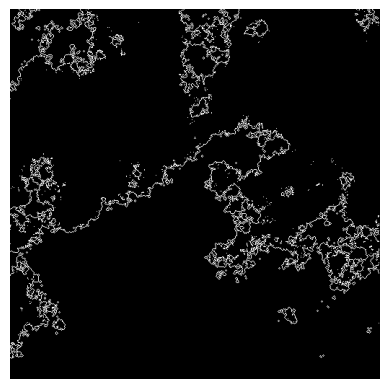

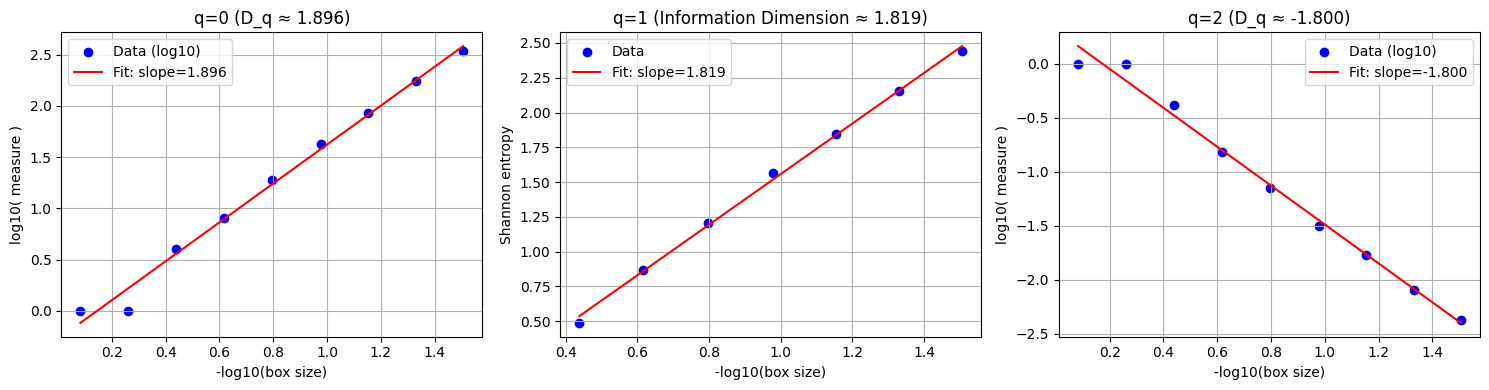

q=0 => Dimension ~ 1.896, R^2=0.990
q=1 => Dimension ~ 1.819, R^2=0.998
q=2 => Dimension ~ -1.800, R^2=0.989


In [36]:
if __name__ == "__main__":
    # Example: Suppose you have a 100x100 binary image
    # Let's create a random "binary fractal-like" for demonstration
    import numpy as np

    im = io.imread('test_images/fractal_42.tif')

    np.random.seed(42)
    image_example = (np.random.rand(100, 100) < 0.2).astype(int)
    
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()

    # We'll test box sizes from 2 to 32
    min_size = 16   
    max_size = 640
    sizes = np.logspace(np.log10(min_size),np.log10(max_size),10).astype(int)
    # We'll compute D_0, D_1, D_2

    q_vals = [0, 1, 2]
    
    results = compute_renyi_dimensions(
        image=im,
        q_values=q_vals,
        sizes=sizes,
        num_offsets=10,     # let's test 3 offsets: centered + 2 random
        do_plot=True,      # show plots
        random_seed=123
    )
    
    # Print out the dimension estimates:
    for q in q_vals:
        dim = results[q]["dimension"]
        r2 = results[q]["r2"]
        print(f"q={q} => Dimension ~ {dim:.3f}, R^2={r2:.3f}")
